### Lid-driven cavity

This example is to show that the MRM toolbox is very flexible and that even incompressible Navier-Stokes kan be simulated. The setup is quite complex because of the usage of a staggered mesh. A surprising finding is that in almost all cases the direct sparse solver is faster (or as fast) is ilu + bicgstab. 

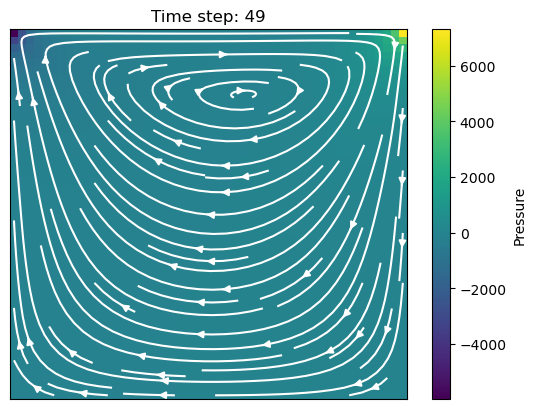

In [6]:
import numpy as np
import scipy as sp
from scipy.sparse import linalg as sla
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from pymrm import interp_stagg_to_cntr, interp_cntr_to_stagg, interp_cntr_to_stagg_tvd
from pymrm import construct_convflux_upwind, construct_grad, construct_div, NumJac, upwind, minmod

# Physical Parameters
dim = 2 
rho = 1
mu = 1
p_top = 0
v_top = 50
box   = [1.0] * dim

# Numerical Parameters
shape_p  = [50] * dim
Co = 0.5
dt = Co*(box[0]/v_top)/shape_p[0]
num_time_steps = 50

x_cntr_c  = [None] * dim # positions cell faces
x_cntr_f  = [None] * dim # cell centered-positions 
x_stagg_c = [None] * dim # staggered positions for velocities
x_stagg_f = [None] * dim # face-positions corresponding to staggered cells
shape_v   = [None] * dim # sizes velocity ndarrays
bc_v      = [None] * dim # velocity bc
v         = [None] * dim
v_old     = [None] * dim
v_cntr    = [None] * dim
Grad_v    = [None] * dim
grad_bc_v = [None] * dim
Div_v     = [None] * dim
Lapl_v    = [None] * dim
lapl_bc_v = [None] * dim
Jac_v     = [None] * dim
Jac_v_pc  = [None] * dim
g_v       = [None] * dim
bc_p      = [None] * dim
Grad_p    = [None] * dim
grad_bc_p = [None] * dim
Div_p     = [None] * dim
p = p_top*np.ones(shape_p)
Lapl_p    = sp.sparse.csc_array((p.size, p.size))
lapl_bc_p = sp.sparse.csc_array((p.size, 1))

for i in range(dim):
    shape_v[i] = shape_p.copy();
    x_cntr_f[i]  = np.linspace(0,box[i],shape_p[i]+1)
    x_cntr_c[i]  = 0.5*(x_cntr_f[i][:-1]+x_cntr_f[i][1:])
    x_stagg_c[i] = x_cntr_f[i][1:-1]
    x_stagg_f[i] = np.concatenate((x_cntr_f[i][0:1], x_cntr_c[i][1:-1], x_cntr_f[i][-1:]), axis=0)
    bc_p[i] = ({'a': 1, 'b': 0, 'd': 0},)*2
    bc_v[i] = [None] * dim
    for j in range(dim):
        shape_v[i][j] = shape_p[j]
        bc_v[i][j] = ({'a': 0, 'b': 1, 'd': 0},{'a': 0, 'b': 1, 'd': 0})
    shape_v[i][i] -= 1
bc_p[-1] = ({'a': 1, 'b': 0, 'd': 0},{'a': 0, 'b': 1, 'd': p_top})
bc_v[0][-1][1]['d'] = v_top
if (dim ==3):
    bc_v[1][-1][1]['a'] = 1
    bc_v[1][-1][1]['b'] = 0
    bc_v[1][-1][1]['d'] = 0

for i in range(dim):
    Grad_p[i], grad_bc_p[i] = construct_grad(shape_p, x_cntr_f[i], x_cntr_c[i] , bc_p[i], axis=i)
    Div_p[i] = construct_div(shape_p, x_cntr_f[i], nu=0, axis=i)
    Lapl_p = Lapl_p + Div_p[i] @ Grad_p[i]
    lapl_bc_p = lapl_bc_p + Div_p[i] @ grad_bc_p[i]
    
    Grad_v[i]    = [None] * dim  
    grad_bc_v[i] = [None] * dim
    Div_v[i]     = [None] * dim 
    v[i] = np.zeros(shape_v[i])
    Lapl_v[i] = sp.sparse.csc_array((v[i].size,v[i].size))
    lapl_bc_v[i] = sp.sparse.csc_array((v[i].size,1))
    for j in range(dim):
        if (i==j):
            Grad_v[i][j], grad_bc_v[i][j] = construct_grad(shape_v[i], x_stagg_f[j], x_stagg_c[j] , bc_v[i][j], axis=j)
            Div_v[i][j] = construct_div(shape_v[i], x_stagg_f[j], nu=0, axis=j)
        else:
            Grad_v[i][j], grad_bc_v[i][j] = construct_grad(shape_v[i], x_cntr_f[j], x_cntr_c[j] , bc_v[i][j], axis=j)
            Div_v[i][j] = construct_div(shape_v[i], x_cntr_f[j], nu=0, axis=j)
        Lapl_v[i] = Lapl_v[i] + Div_v[i][j] @ Grad_v[i][j]
        lapl_bc_v[i] = lapl_bc_v[i] + Div_v[i][j] @ grad_bc_v[i][j]
    Jac_v[i] = (rho/dt) * sp.sparse.eye(v[i].size, format='csc') - mu * Lapl_v[i]
    Jac_v_ilu = sla.spilu(Jac_v[i])
    Jac_v_pc[i] = sla.LinearOperator(Jac_v_ilu.shape, lambda x: Jac_v_ilu.solve(x))
Lapl_p_ilu = sla.spilu(Lapl_p)
Lapl_p_lu = sla.splu(Lapl_p)
Lapl_p_pc = sla.LinearOperator(Lapl_p_ilu.shape, lambda x: Lapl_p_ilu.solve(x))

X, Y = np.meshgrid(x_cntr_c[0], x_cntr_c[1])

for k in range(num_time_steps):
    div_v = np.zeros((p.size,1))
    for i in range(dim):
        v_old[i] = v[i].copy()
        g_conv = np.zeros((v[i].size,1))
        for j in range(dim):
            if (j == i):
                v_f = interp_cntr_to_stagg(v[i], x_stagg_f[i], x_stagg_c[i], axis = i)
                vi_f, dvi_f = interp_cntr_to_stagg_tvd(v[i], x_stagg_f[i], x_stagg_c[i], bc_v[i][j], v_f, minmod, axis=j)
                conv_flux = rho*vi_f*vi_f            
            else:
                v_f = interp_stagg_to_cntr(v[j], x_cntr_c[i], x_stagg_c[i], axis = i)
                shape_v_f_bnd = list(v_f.shape)
                shape_v_f_bnd[j] = 1
                v_f = np.concatenate((np.zeros(shape_v_f_bnd), v_f , np.zeros(shape_v_f_bnd)),axis=j)
                vi_f, dvi_f = interp_cntr_to_stagg_tvd(v[i], x_cntr_f[j], x_cntr_c[j], bc_v[i][j], v_f, minmod, axis=j)
                conv_flux = rho*v_f*vi_f
            g_conv = g_conv + Div_v[i][j] @ conv_flux.reshape(-1,1)
        shape_p_f = shape_p.copy()
        shape_p_f[i] = shape_p[i]+1
        grad_p = (Grad_p[i] @ p.reshape(-1,1) + grad_bc_p[i]).reshape(shape_p_f)
        idx = [slice(None)] * dim
        idx[i] = slice(1, shape_p_f[i]-1)
        g_grad_p = grad_p[tuple(idx)].reshape(-1,1)                
        g_v[i] = Jac_v[i] @ v[i].reshape(-1,1) - (rho/dt)*v_old[i].reshape(-1,1) + g_conv + g_grad_p - mu*lapl_bc_v[i]
        dv, exit_code = sla.bicgstab(Jac_v[i], g_v[i], M=Jac_v_pc[i])
        #Jac_lu = sla.splu(Jac_v[i])
        #dv = Jac_lu.solve(g_v[i])
        v[i] -= dv.reshape(shape_v[i])
            
        shape_v_bnd = list(v[i].shape)
        shape_v_bnd[i] = 1
        v_incl_wall = np.concatenate((np.zeros(shape_v_bnd), v[i] , np.zeros(shape_v_bnd)),axis=i)
        v_cntr[i] = interp_stagg_to_cntr(v_incl_wall, x_cntr_f[i], x_cntr_c[i], axis = i)
        div_v += Div_p[i] @ v_incl_wall.reshape(-1,1)

    #dp, exit_code = sla.bicgstab(Lapl_p, (rho/dt)*div_v, M=Lapl_p_pc)
    dp = Lapl_p_lu.solve((rho/dt)*div_v)
    p += dp.reshape(shape_p)
    for i in range(dim):
        shape_p_f = shape_p.copy()
        shape_p_f[i] = shape_p[i]+1
        grad_dp = (Grad_p[i] @ dp.reshape(-1,1)).reshape(shape_p_f)
        idx = [slice(None)] * dim
        idx[i] = slice(1, shape_p_f[i]-1)
        v[i] -= (dt/rho) * grad_dp[tuple(idx)]
        shape_v_bnd = list(v[i].shape)
        shape_v_bnd[i] = 1
        v_incl_wall = np.concatenate((np.zeros(shape_v_bnd), v[i] , np.zeros(shape_v_bnd)),axis=i)
        v_cntr[i] = interp_stagg_to_cntr(v_incl_wall, x_cntr_f[i], x_cntr_c[i], axis = i)
    clear_output(wait=True)
    plt.figure()
    contour = plt.pcolormesh(x_cntr_f[0], x_cntr_f[1], p.T, shading='flat', cmap='viridis')
    plt.streamplot(X, Y, v_cntr[0].T, v_cntr[1].T, color = 'white')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(contour, label='Pressure')
    plt.title(f"Time step: {k}")
    plt.show()